In [1]:
from hepmc import *
from hepmc import densities
from hepmc.surrogate.extreme_learning import *
import numpy as np
np.random.seed(12345)
import matplotlib.pyplot as plt

Can't find Sherpa installation, skipping ee_qq.


data (size),mean,variance,bin-wise chi^2,effective sample size
3100,[0.49434404 0.49591812],[0.03530638 0.03390969],"1.494, p=0.04247, N=30",[3100. 3100.]


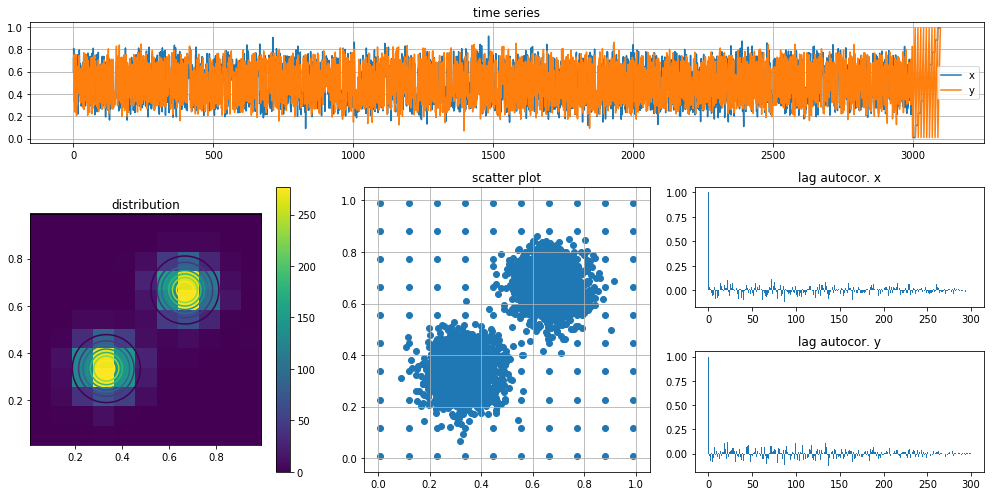

In [2]:
ndim = 2
n_train = 3000

target = densities.Camel(ndim)
is_proposal_weights = np.array(ndim*[.5])
channels = MultiChannel([
    densities.Gaussian(ndim, mu=1/3, cov=.005), 
    densities.Gaussian(ndim, mu=2/3, cov=.005)], 
    is_proposal_weights)

sampler = AcceptRejectSampler(target, 1, ndim, channels.rvs, channels)
train_sample = sampler.sample(n_train)
train_sample.data = train_sample.data[np.random.choice(np.arange(n_train), n_train, replace=False)]

# add some points in the low-probability region
x = np.linspace(0.01, .99, 10)
y = np.linspace(0.01, .99, 10)
xs = [[x_i, y_j] for x_i in x for y_j in y]
train_sample.extend_array('data', xs)

train_fn_values = target.pot(train_sample.data)
train_sample

In [3]:
basis = GaussianBasis(ndim)
n_nodes = 60
params, bias, weights = basis.extreme_learning_train(train_sample.data, train_fn_values, n_nodes)

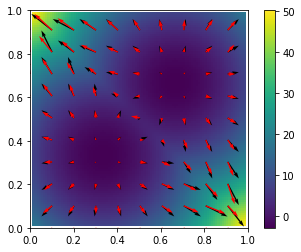

In [4]:
x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)
mgrid = np.meshgrid(x, y)
xs = [[x_i, y_j] for x_i in x for y_j in y]
fn_values = target.pot(xs)
grad = target.pot_gradient(xs)
fn_values = np.reshape(fn_values, (100, 100))
grad = np.reshape(grad, (100, 100, 2))

learned = basis.eval_gradient_split(params, bias, weights, *mgrid)


plt.imshow(fn_values, origin='lower', extent=[0, 1, 0, 1])
plt.colorbar()
#grad[:, :, 0]
plt.quiver(x[::10], y[::10], grad[::10, ::10, 1], grad[::10, ::10, 0])
#plt.quiver(x[10:-10:10], y[10:-10:10], learned[10:-10:10, 10:-10:10, 0], learned[10:-10:10, 10:-10:10, 1], color='r')
plt.quiver(x[::10], y[::10], learned[::10, ::10, 0], learned[::10, ::10, 1], color='r')

plt.savefig('camel_gradient_surrogate.pdf', bbox_inches='tight', pad_inches=0, dpi=200)

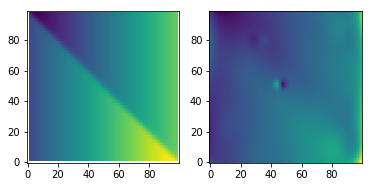

In [5]:
plt.subplot(121)
plt.imshow(grad[:, :, 1], origin='lower')
plt.subplot(122)
plt.imshow(learned[:, :, 0], origin='lower')

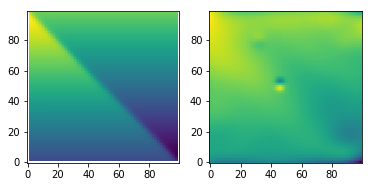

In [6]:
plt.subplot(121)
plt.imshow(grad[:, :, 0], origin='lower')
plt.subplot(122)
plt.imshow(learned[:, :, 1], origin='lower')

In [7]:
# build_tree function that returns all steps
def build_tree(q, p, u, v, j, step_size, q0, p0, Emax):
    if j == 0:
        trajectory = []
        q_prime, p_prime = nuts.simulate_custom(q, p, 1, v*step_size)
        dE = nuts.target_density.pdf(q_prime)/nuts.p_dist.pdf(p_prime)
        dE0 = nuts.target_density.pdf(q0)/nuts.p_dist.pdf(p0)
        n_prime = (u <= dE)
        s_prime = (u < Emax*dE)
        trajectory.append(q_prime)
        return (q_prime, p_prime, q_prime, p_prime, q_prime, n_prime, s_prime, trajectory)
    
    else:
        (q_minus, p_minus, q_plus, p_plus, q_prime, n_prime, s_prime, trajectory) = build_tree(q, p, u, v, j-1, step_size, q0, p0, Emax)

        if s_prime == 1:
            if v == -1:
                (q_minus, p_minus, _, _, q_2prime, n_2prime, s_2prime, trajectory_prime) = build_tree(q_minus, p_minus, u, v, j-1, step_size, q0, p0, Emax)
                
            else:
                (_, _, q_plus, p_plus, q_2prime, n_2prime, s_2prime, trajectory_prime) = build_tree(q_plus, p_plus, u, v, j-1, step_size, q0, p0, Emax)
        
            trajectory += trajectory_prime

            if np.random.uniform() < n_2prime/(n_prime + n_2prime):
                q_prime = q_2prime
            dq = q_plus - q_minus
            s_prime = (s_2prime*(np.dot(dq, p_minus) >= 0)*(np.dot(dq, p_plus) >= 0))
            n_prime = n_prime + n_2prime
        
        return (q_minus, p_minus, q_plus, p_plus, q_prime, n_prime, s_prime, trajectory)

In [8]:
# proposal function that returns all steps
def proposal(current, current_pdf):
    trajectory = [current]
    p0 = nuts.p_dist.proposal()
    print('p0:', p0)
    u = np.random.uniform(0, current_pdf / nuts.p_dist.pdf(p0))
    q_minus, q_plus, p_minus, p_plus, q = current, current, p0, p0, current
    j, n, s = 0, 1, 1
    
    while s == 1:
        v = np.random.choice([-1, 1])
        if v == -1:
            (q_minus, p_minus, _, _, q_prime, n_prime, s_prime, trajectory_prime) = build_tree(q_minus, p_minus, u, v, j, nuts.step_size, q, p0, nuts.Emax)
            trajectory = trajectory_prime + trajectory
        else:
            (_, _, q_plus, p_plus, q_prime, n_prime, s_prime, trajectory_prime) = build_tree(q_plus, p_plus, u, v, j, nuts.step_size, q, p0, nuts.Emax)
            trajectory = trajectory + trajectory_prime
        
        if s_prime == 1 and np.random.uniform() < min(1, n_prime/n):
            q = q_prime
        
        dq = q_plus - q_minus
        n = n + n_prime
        s = s_prime * (np.dot(dq, p_minus) >= 0) * (np.dot(dq, p_plus) >= 0)
        j = j + 1
    
    q_pdf = nuts.target_density.pdf(q)
    return q, q_pdf, trajectory

p0: [ 0.47143516 -1.19097569]
q: [0.2075692  0.25101996]
p0: [-2.07388211 -0.16158804]
q: [0.23566325 0.35416685]
p0: [ 0.60430874 -0.18301422]
q: [0.29029621 0.33980776]
p0: [-2.22745688 -0.67481994]
q: [0.29029621 0.33980776]


/net/theorie/home/tjansse2/studium/masterarbeit/hep-monte-carlo/hepmc_env/lib64/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide


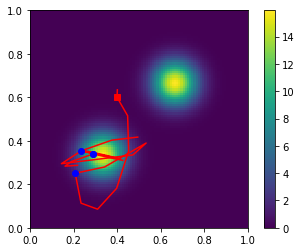

In [9]:
np.random.seed(1234)

fn_values = target.pdf(xs)
fn_values = np.reshape(fn_values, (100, 100))

plt.imshow(fn_values, origin='lower', extent=[0, 1, 0, 1])
plt.colorbar()

momentum_dist = densities.Gaussian(ndim, scale=1)
nuts = hamiltonian.NUTSUpdate(target, momentum_dist, lambda x : False)
nuts.step_size = .05

q = np.array([.4, .6])
q_pdf = nuts.target_density.pdf(q)
plt.plot(q[0], q[1], 'rs')

n = 4

for i in range(n):
    q, q_pdf, trajectory = proposal(q, q_pdf)
    print('q:', q)
    trajectory = np.array(trajectory).transpose()
    plt.plot(trajectory[0], trajectory[1], 'r-', zorder=1)
    plt.plot(q[0], q[1], 'bo', zorder=2)
    
plt.savefig('trajectory_real.pdf', bbox_inches='tight', pad_inches=0, dpi=200)

In [10]:
def surrogate_gradient(xs):
    return basis.eval_gradient_split(params, bias, weights, xs)

surrogate = densities.Camel(2)
surrogate.pot_gradient = surrogate_gradient

p0: [ 0.47143516 -1.19097569]
q: [0.37591714 0.41243473]
p0: [-0.00867858 -0.32106129]
q: [0.30385021 0.29366262]
p0: [-0.68992667  0.18749737]
q: [0.27803378 0.31054301]
p0: [ 0.86371729 -0.12209157]
q: [0.33605664 0.31815854]


/net/theorie/home/tjansse2/studium/masterarbeit/hep-monte-carlo/hepmc_env/lib64/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide


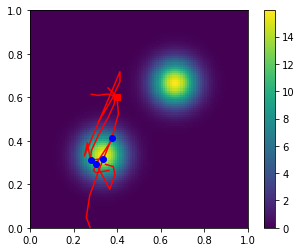

In [11]:
np.random.seed(1234)

plt.imshow(fn_values, origin='lower', extent=[0, 1, 0, 1])
plt.colorbar()
plt.xlim((0, 1))
plt.ylim((0, 1))

nuts = hamiltonian.NUTSUpdate(surrogate, momentum_dist, lambda x : False)
nuts.step_size = .05

q = np.array([.4, .6])
q_pdf = nuts.target_density.pdf(q)
plt.plot(q[0], q[1], 'rs')

n = 4

for i in range(n):
    q, q_pdf, trajectory = proposal(q, q_pdf)
    print('q:', q)
    trajectory = np.array(trajectory).transpose()
    plt.plot(trajectory[0], trajectory[1], 'r-', zorder=1)
    plt.plot(q[0], q[1], 'bo', zorder=2)
    
plt.savefig('trajectory_surrogate.pdf', bbox_inches='tight', pad_inches=0, dpi=200)